## Import

In [6]:
# !pip install pandas
# !pip install numpy
# # install sklearn
# !pip install scikit-learn
# !pip install tqdm


In [12]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import gc
import warnings


warnings.filterwarnings(action='ignore') 

# Device & Path

In [3]:
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# torch.backends.mps.is_available()

In [4]:
# PATH
DATA_PATH  = '../DATA'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TRAIN_CSV  = os.path.join(DATA_PATH, 'train.csv')
SAMPLE_PATH = os.path.join(DATA_PATH, 'sample_submission.csv')

## Hyperparameter Setting

In [6]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':1,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':64,
    'SEED':41
}

## Fixed RandomSeed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = True


seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [61]:
df_train = pd.read_csv(TRAIN_CSV)
df_ss = pd.read_csv(SAMPLE_PATH)
df_train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2920,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5780,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,34400,35600,34150,34400
3,20210601,A054620,APS,462544,14950,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29050,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,2980,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3215,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1370,1395,1340,1370
987998,20230530,A037440,희림,141932,9200,9260,9170,9200


## File Description
- [train.csv] - 2021년 6월 1일부터 2023년 5월 30일까지의 일별 시세정보


- [sample_submission.csv] [파일] - 제출 양식
종목코드 : 각 주식종목의 고유 코드
순위 : 거래행위 결정을 위한 수익률 순위
1~200위는 매수 (Long)
1801위부터 2000위는 공매도 (Short)


In [62]:
df_train.columns

Index(['일자', '종목코드', '종목명', '거래량', '시가', '고가', '저가', '종가'], dtype='object')

## columns 
1. '일자': 이 컬럼은 특정 거래가 발생한 날짜를 나타냅니다. "YYYY-MM-DD" 형식으로 표현됩니다.

2. '종목코드': 각각의 주식을 식별하는 고유한 코드입니다. 한국의 경우 종목코드는 대부분 6자리 숫자로 이루어져 있습니다. (ex - A060310)

3. '종목명': 주식의 공식 이름을 나타냅니다. 이 이름은 주로 회사의 이름을 반영하며, 시장에서 해당 주식을 찾을 때 사용됩니다.

4. '거래량': 특정 일자에 해당 주식이 거래된 총 주식 수를 나타냅니다. 거래량은 시장의 활동 수준과 관심도를 반영하는 중요한 지표입니다.

5. '시가': 주식 시장이 개장했을 때의 첫 거래 가격을 의미합니다. 이는 해당 날의 시장 흐름을 이해하는데 도움이 됩니다.

6. '고가': 특정 일자에 해당 주식이 거래된 가장 높은 가격을 나타냅니다.

7. '저가': 특정 일자에 해당 주식이 거래된 가장 낮은 가격을 나타냅니다.

8. '종가': 주식 시장이 마감했을 때의 마지막 거래 가격을 의미합니다. 종가는 해당 일의 주식 가격 변동을 반영하며, 이후의 시장 분석에 중요한 기준이 됩니다.

In [76]:
# change columns name
df = df_train.rename(columns={
    '일자': 'date',
    '종목코드': 'code',
    '종목명': 'name',
    '거래량': 'volume',
    '시가': 'open',
    '고가': 'high',
    '저가': 'low',
    '종가': 'close'
})
df.head(5)

,date,code,name,volume,open,high,low,close
0,20210601,A060310,3S,166690,2920,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5780,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,34400,35600,34150,34400
3,20210601,A054620,APS,462544,14950,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29050,29150,28800,29050


# Simple Summary


In [54]:
def summarize(df, file_name, n_rows_to_show=5):
    """Simply summarize the given DataFrame.
    
    Parameters:
        df: pd.DataFrame, raw DataFrame
        file_name: str, name of the file
        n_rows_to_show: int, number of rows to show 
    """
    print(f"=====Summary of {file_name}=====")
    print(f"Shape: {df.shape}")
    
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
    print("NaN ratio:")
    display(nan_ratio)   
    
    display(df.head(n_rows_to_show))

In [55]:
summarize(df, 'train.csv')

=====Summary of train.csv=====
Shape: (988000, 8)
NaN ratio:


,date,code,name,volume,open,high,low,close
NaN Ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,date,code,name,volume,open,high,low,close
0,20210601,A060310,3S,166690,2920,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5780,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,34400,35600,34150,34400
3,20210601,A054620,APS,462544,14950,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29050,29150,28800,29050


In [56]:
df.drop(columns='date').describe()

,volume,open,high,low,close
count,9.880000e+05,9.880000e+05,9.880000e+05,9.880000e+05,9.880000e+05
mean,7.734265e+05,2.600283e+04,2.634938e+04,2.542335e+04,2.600283e+04
std,4.839914e+06,6.587082e+04,6.689822e+04,6.490307e+04,6.587082e+04
min,0.000000e+00,8.500000e+01,0.000000e+00,0.000000e+00,8.500000e+01
25%,3.653900e+04,3.890000e+03,3.865000e+03,3.700000e+03,3.890000e+03
50%,1.140220e+05,8.700000e+03,8.810000e+03,8.470000e+03,8.700000e+03
75%,3.672998e+05,2.140000e+04,2.180000e+04,2.085000e+04,2.140000e+04
max,7.822434e+08,1.770000e+06,1.784000e+06,1.756000e+06,1.770000e+06


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988000 entries, 0 to 987999
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    988000 non-null  int64 
 1   code    988000 non-null  object
 2   name    988000 non-null  object
 3   volume  988000 non-null  int64 
 4   open    988000 non-null  int64 
 5   high    988000 non-null  int64 
 6   low     988000 non-null  int64 
 7   close   988000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 60.3+ MB


In [79]:
# datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.dtypes

date      datetime64[ns]
code              object
name              object
volume             int64
open               int64
high               int64
low                int64
close              int64
dtype: object

In [34]:
!pip install fasteda

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 2.4 MB/s eta 0:00:0000:0100:01
  Created wheel for fasteda: filename=fasteda-1.0.1-py3-none-any.whl size=4739 sha256=fa788562dc11cd6f81ab0f46a072721f6f679e962b59b05d28487906c934b46f
  Stored in directory: /home/dsj/.cache/pip/wheels/ed/08/72/0d0ec0d3927d227b38ce9542ec3fa6b975c2e17ad0d046dcee
Successfully built fasteda


DataFrame Head:


,date,volume,open,high,low,close
0,20210601,166690,2920,2970,2885,2920
1,20210601,63836,5780,5940,5750,5780
2,20210601,103691,34400,35600,34150,34400


DataFrame Tail:


,date,volume,open,high,low,close
987997,20230530,130664,1370,1395,1340,1370
987998,20230530,141932,9200,9260,9170,9200
987999,20230530,2611843,8220,8220,6300,8220


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(988000, 6)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988000 entries, 0 to 987999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   date    988000 non-null  int64
 1   volume  988000 non-null  int64
 2   open    988000 non-null  int64
 3   high    988000 non-null  int64
 4   low     988000 non-null  int64
 5   close   988000 non-null  int64
dtypes: int64(6)
memory usage: 45.2 MB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
date,988000,20219739.919,20220530.5,6822.396,20210601,20211129,20220530.5,20221129,20230530,0.118081,-0.982782
volume,988000,773426.518,114022,4839914.236,0,36539,114022,367299.75,782243419,40.243932,3299.510905
open,988000,26002.83,8700,65870.824,85,3890,8700,21400,1770000,8.315905,100.410207
high,988000,26349.384,8810,66898.216,0,3865,8810,21800,1784000,8.293444,99.728674
low,988000,25423.35,8470,64903.067,0,3700,8470,20850,1756000,8.353705,101.516805
close,988000,26002.83,8700,65870.824,85,3890,8700,21400,1770000,8.315905,100.410207


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



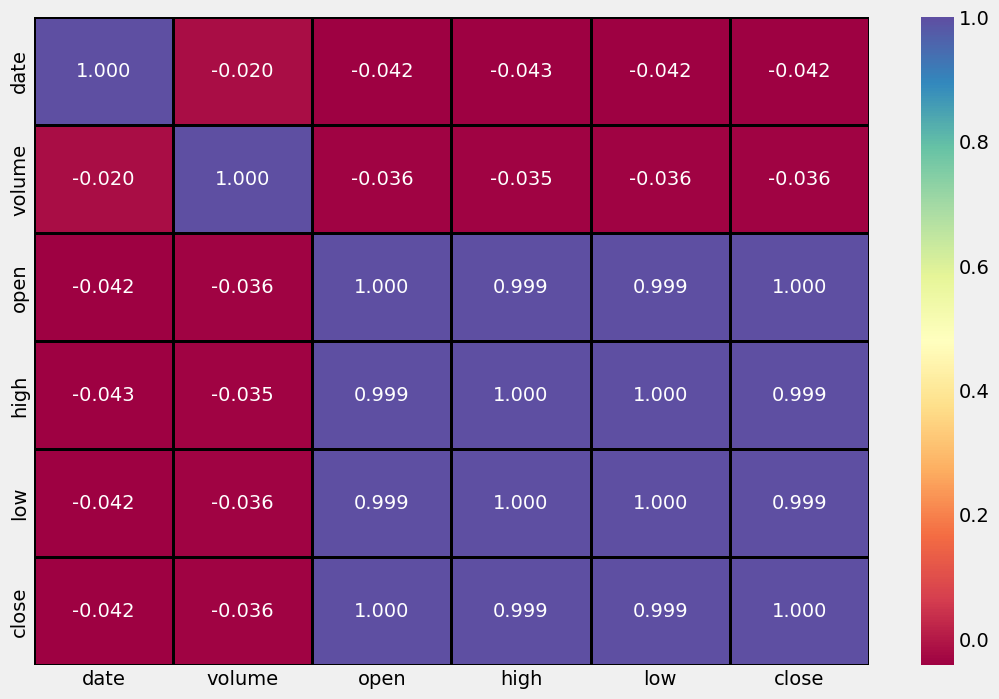

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



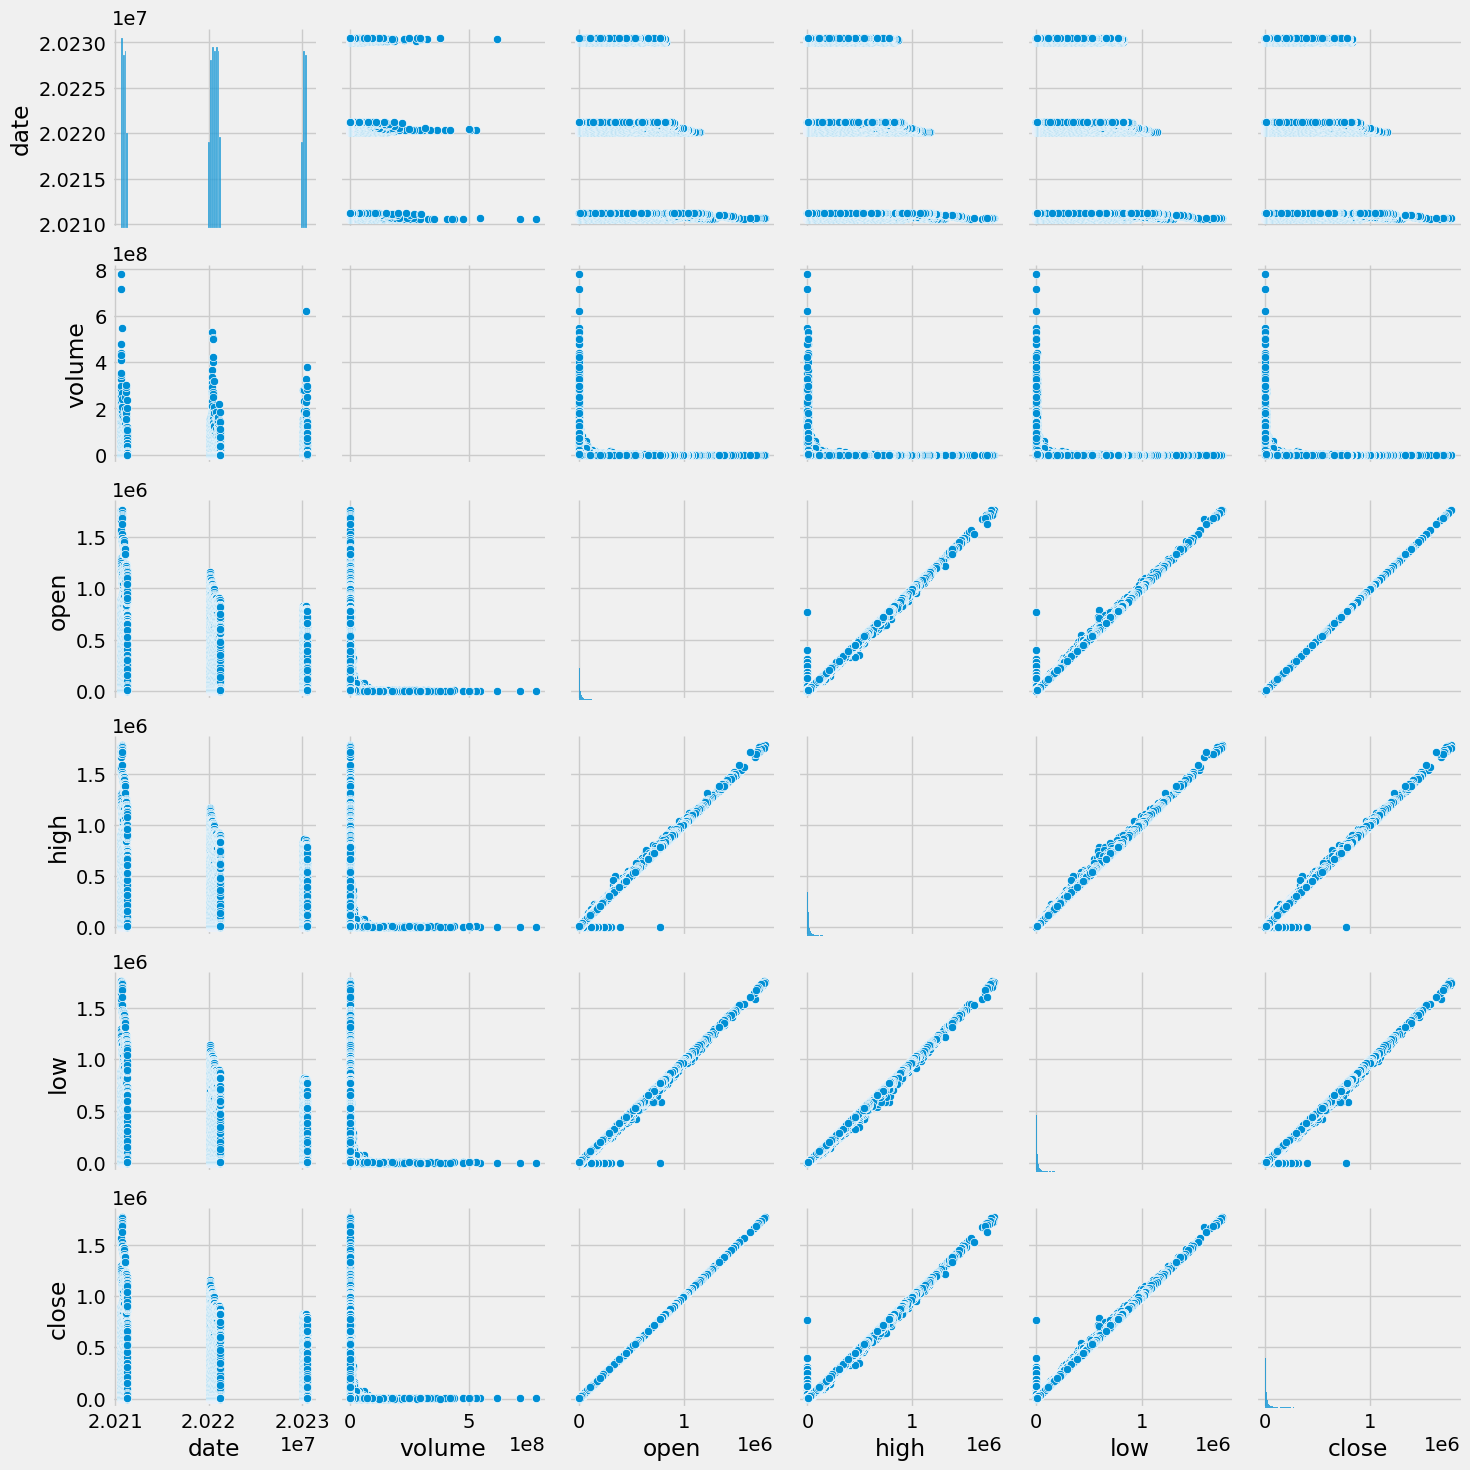

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



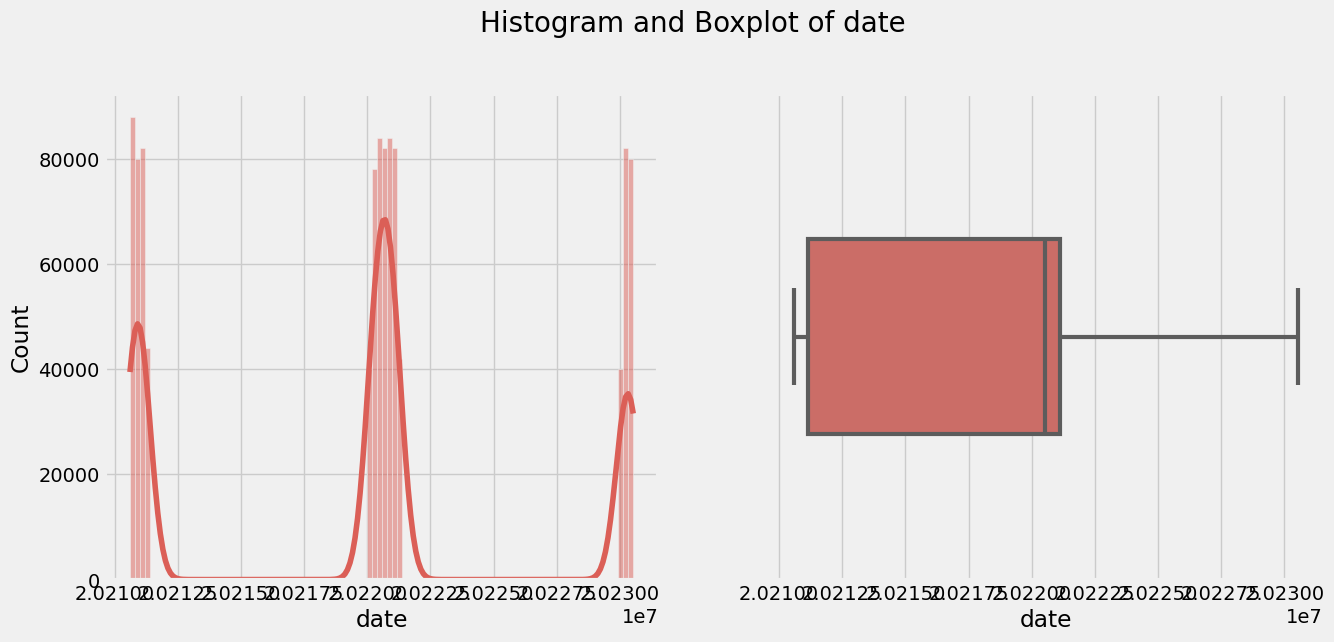

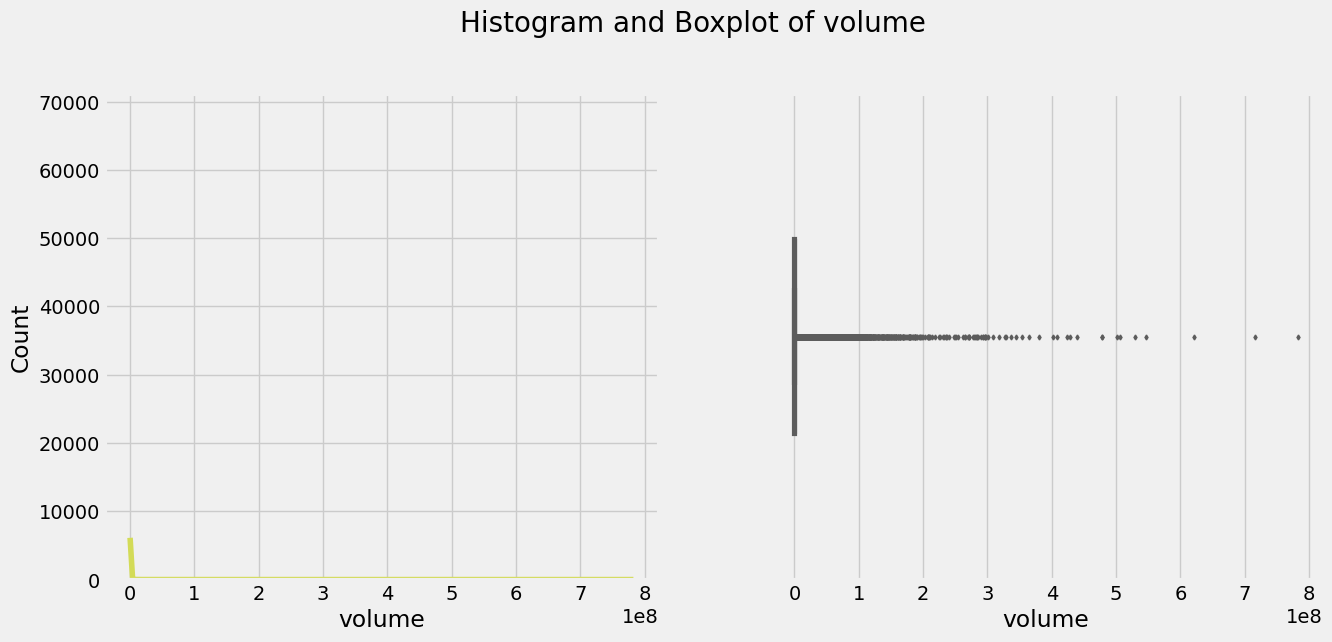

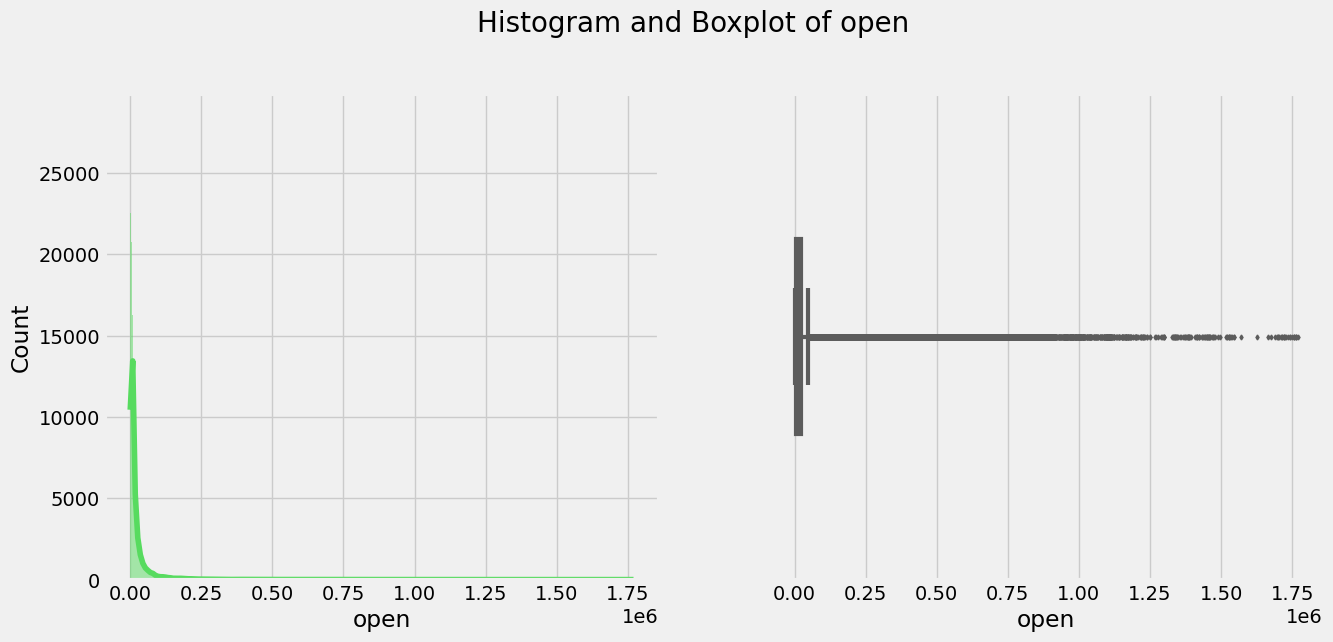

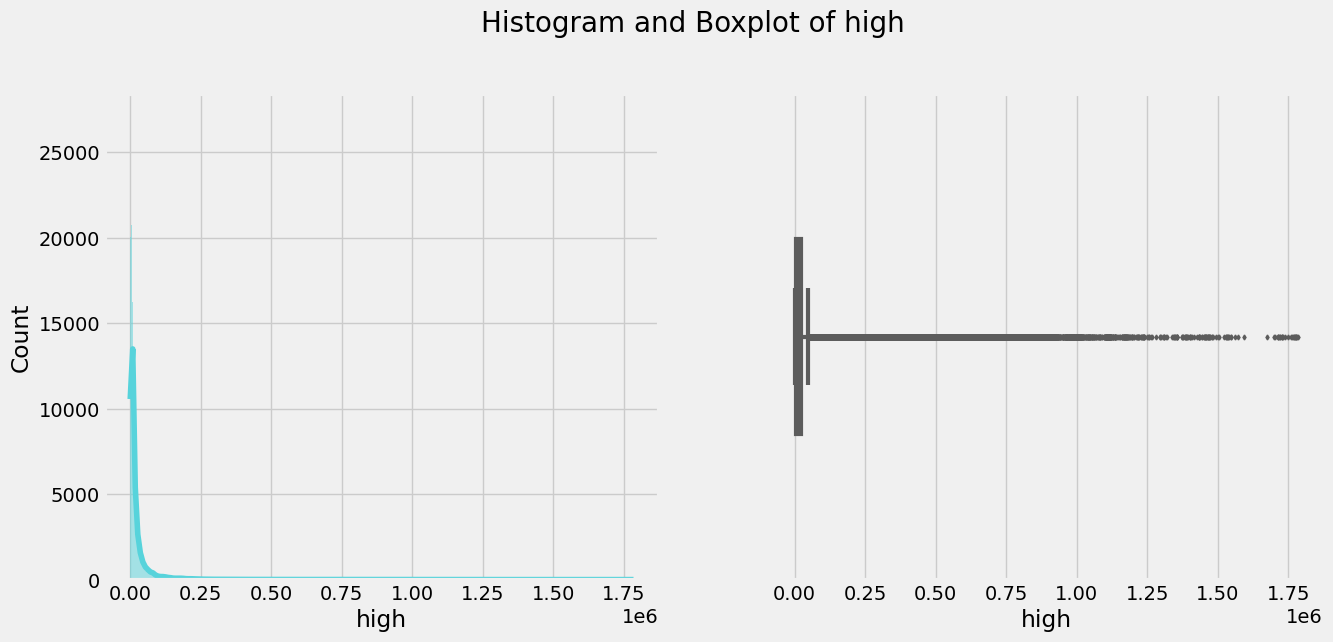

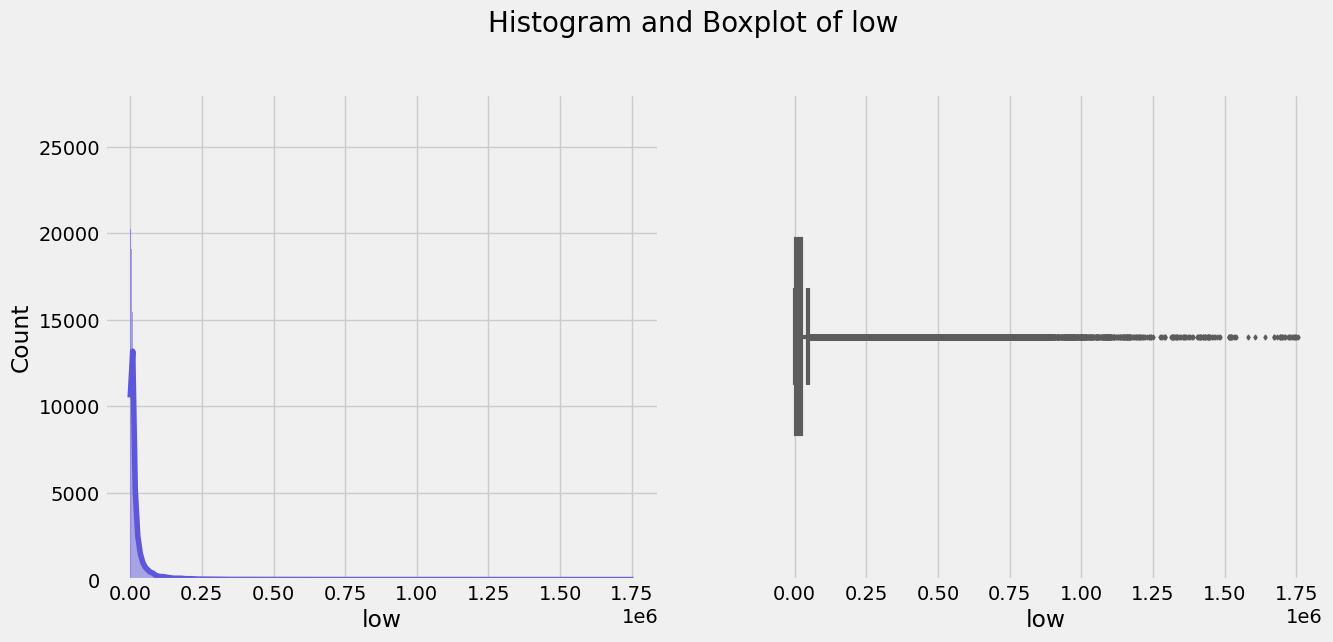

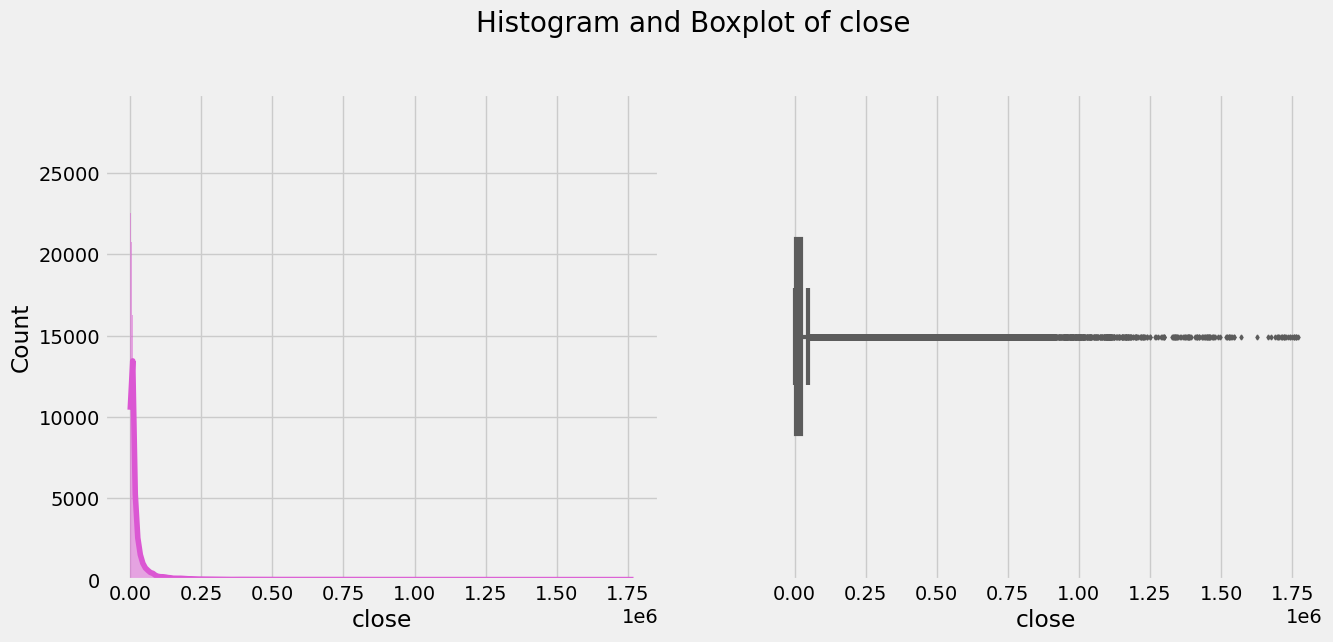

In [41]:
from fasteda import fast_eda as fe
fe(df.drop(columns=['code','name']))

In [80]:
df_no_prices = df[df['close'].isna()]
print(f"Number of samples without prices: {len(df_no_prices)}")

Number of samples without prices: 0


In [81]:
# min max data
print(f'min of data is {df.date.min()}')
print(f'max of date is {df.date.max()}')
print(f'sum of days are {df.date.max()-df.date.min()}')

df_test = df[df['code']=='A238490'].copy()
# weekend
df_test['is_weekend'] = df_test['date'].apply(lambda x: x.weekday() >= 5)

# 'is_weekend' columns False count 
weekday_count = df_test[~df_test['is_weekend']].shape[0]

print(f"Number of weekdays: {weekday_count}")

min of data is 2021-06-01 00:00:00
max of date is 2023-05-30 00:00:00
sum of days are 728 days 00:00:00
Number of weekdays: 494


In [82]:
# maybe one code has 494 counts
df.code.value_counts()

code
A238490    494
A060310    494
A095570    494
A006840    494
A054620    494
          ... 
A051500    494
A058820    494
A023460    494
A056730    494
A083660    494
Name: count, Length: 2000, dtype: int64

In [74]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.7 MB/s eta 0:00:0000:0100:01


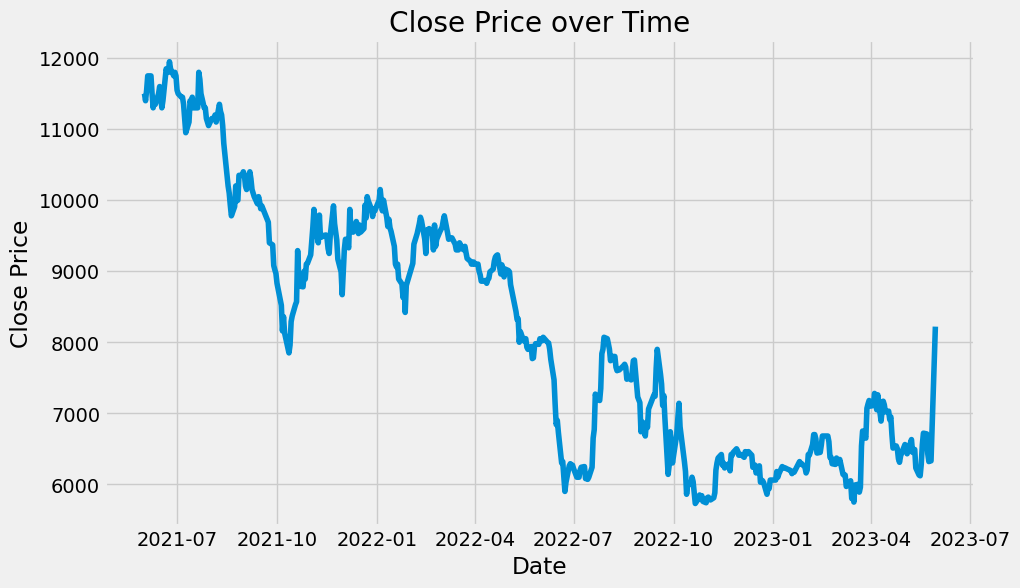

In [73]:
# df_test close plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_test['date'], df_test['close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price over Time')
plt.show()

In [83]:
df_price = df.pivot(index='date', columns='code', values='close')
df_price

code,A000020,A000040,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000180,A000210,A000220,A000230,A000240,A000250,A000270,A000300,A000320,A000370,A000390,A000400,A000430,A000440,A000480,A000490,A000500,A000520,A000540,A000590,A000640,A000650,A000660,A000670,A000680,A000700,A000720,A000760,A000810,A000850,A000860,A000880,A000890,A000910,A000950,A000970,A000990,A001000,A001020,A001040,A001060,A001070,A001080,A001120,A001130,A001140,A001200,A001230,A001250,A001260,A001270,A001290,A001340,A001360,A001380,A001390,A001430,A001440,A001450,A001460,A001470,A001500,A001510,A001520,A001530,A001540,A001550,A001560,A001570,A001620,A001630,A001680,A001720,A001740,A001750,A001780,A001790,A001800,A001810,A001820,A001840,A001880,A001940,A002020,A002030,A002100,A002140,A002150,A002170,A002200,A002210,A002220,A002230,A002240,A002290,A002310,A002320,A002350,A002360,A002380,A002390,A002410,A002450,A002460,A002600,A002620,A002630,A002680,A002690,A002700,A002710,A002720,A002760,A002780,A002790,A002800,A002810,A002840,A002880,A002900,A002920,A002960,A002990,A003000,A003010,A003030,A003060,A003070,A003080,A003090,A003100,A003120,A003160,A003200,A003220,A003230,A003240,A003280,A003300,A003310,A003350,A003380,A003410,A003460,A003470,A003480,A003490,A003520,A003530,A003540,A003550,A003560,A003570,A003580,A003610,A003620,A003650,A003670,A003690,A003720,A003780,A003800,A003830,A003850,A003920,A003960,A004000,A004020,A004060,A004080,A004090,A004100,A004140,A004150,A004170,A004250,A004270,A004310,A004360,A004370,A004380,A004410,A004430,A004440,A004450,A004490,A004540,A004560,A004590,A004650,A004690,A004700,A004710,A004720,A004770,A004780,A004800,A004830,A004840,A004870,A004890,A004910,A004920,A004960,A004970,A004980,A004990,A005010,A005070,A005090,A005110,A005160,A005180,A005250,A005290,A005300,A005320,A005360,A005380,A005390,A005420,A005430,A005440,A005490,A005500,A005610,A005670,A005680,A005690,A005710,A005720,A005740,A005750,A005800,A005810,A005820,A005830,A005850,A005860,A005870,A005880,...,A252500,A252990,A253450,A253590,A253840,A254120,A255220,A255440,A256150,A256630,A256840,A256940,A257370,A258610,A258830,A259630,A260660,A260930,A260970,A261200,A262260,A262840,A263020,A263050,A263540,A263600,A263690,A263700,A263720,A263750,A263770,A263800,A263810,A263860,A263920,A264450,A264660,A264850,A264900,A265520,A265560,A265740,A267250,A267260,A267270,A267290,A267320,A267790,A267850,A267980,A268280,A268600,A269620,A270520,A270660,A270870,A271560,A271980,A272110,A272210,A272290,A272450,A272550,A273060,A274090,A276730,A277070,A277410,A277810,A277880,A278280,A278650,A279600,A280360,A281740,A281820,A282330,A282690,A282880,A284620,A284740,A285130,A285490,A286750,A286940,A287410,A288330,A288620,A289010,A289080,A289220,A290120,A290380,A290520,A290550,A290650,A290670,A290690,A290720,A290740,A291230,A291650,A293480,A293490,A293580,A293780,A294090,A294140,A294570,A294630,A294870,A297090,A297570,A297890,A298000,A298020,A298040,A298050,A298060,A298380,A298540,A298690,A299030,A299170,A299660,A299900,A300080,A300120,A300720,A301300,A302430,A302440,A302550,A303030,A303360,A304100,A304840,A305090,A306040,A306200,A306620,A307180,A307280,A307750,A307870,A307930,A307950,A308100,A308170,A309930,A310200,A311390,A311690,A312610,A313760,A314130,A314930,A316140,A317120,A317240,A317330,A317400,A317530,A317690,A317770,A317830,A317850,A317870,A318000,A318010,A318020,A318410,A319400,A319660,A320000,A321260,A321550,A322000,A322180,A322310,A322510,A322780,A323280,A323990,A326030,A327260,A330350,A330860,A331520,A332290,A332370,A332570,A333430,A333620,A334970,A335810,A335890,A336060,A336260,A336370,A336570,A337930,A338220,A339770,A339950,A340440,A340570,A340930,A344820,A347700,A347740,A347770,A347860,A347890,A348030,A348150,A348210,A348350,A351320,A351330,A352480,A352700,A352770,A352820,A352940,A353190,A353200,A353810,A354200,A355150,A356860,A356890,A357230,A357550,A357780,A359090,A361390,A361610,A363250,A363260,A363280,A365590,A368770,A369370,A373200,A375500,A378850,A383220,A383310

In [90]:
Code = 'A000020' # Select Security Code

In [88]:
df

,date,code,name,volume,open,high,low,close
0,2021-06-01,A060310,3S,166690,2920,2970,2885,2920
1,2021-06-01,A095570,AJ네트웍스,63836,5780,5940,5750,5780
2,2021-06-01,A006840,AK홀딩스,103691,34400,35600,34150,34400
3,2021-06-01,A054620,APS,462544,14950,14950,13800,14950
4,2021-06-01,A265520,AP시스템,131987,29050,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,2023-05-30,A189980,흥국에프엔비,272284,2980,3035,2955,2980
987996,2023-05-30,A000540,흥국화재,50218,3215,3255,3195,3215
987997,2023-05-30,A003280,흥아해운,130664,1370,1395,1340,1370
987998,2023-05-30,A037440,희림,141932,9200,9260,9170,9200


In [91]:
cols = ['date', 'open', 'high', 'low', 'close', 'volume', 'code']
STOCK = df[df.code==Code][cols].set_index("date")
STOCK

,open,high,low,close,volume,code
date,,,,,,
2021-06-01,14600,14700,14450,14600,114966,A000020
2021-06-02,14500,14700,14450,14500,109559,A000020
2021-06-03,14600,14650,14450,14600,96158,A000020
2021-06-04,14700,14800,14550,14700,133900,A000020
2021-06-07,15150,15550,14750,15150,511140,A000020
...,...,...,...,...,...,...
2023-05-23,9770,9900,9160,9770,641524,A000020
2023-05-24,9740,9820,9550,9740,205243,A000020
2023-05-25,10040,10180,9660,10040,398326,A000020


In [92]:
from itertools import combinations, product

In [93]:
# def absHighPass(df, absThresh):
#     df.loc[:, ]
#     passed = set()
#     for (r,c) in combinations(df.columns, 2):
#         if (abs(df.loc[r,c]) >= absThresh):
#             passed.add(r)
#             passed.add(c)
#     passed = sorted(passed)
#     return df.loc[passed,passed]

# corr = df.corr()

type: could not convert string to float: 'A060310'

In [96]:

STOCK.head()



,open,high,low,close,volume,code
date,,,,,,
2021-06-01,14600,14700,14450,14600,114966,A000020
2021-06-02,14500,14700,14450,14500,109559,A000020
2021-06-03,14600,14650,14450,14600,96158,A000020
2021-06-04,14700,14800,14550,14700,133900,A000020
2021-06-07,15150,15550,14750,15150,511140,A000020


In [97]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [99]:
import seaborn as sns

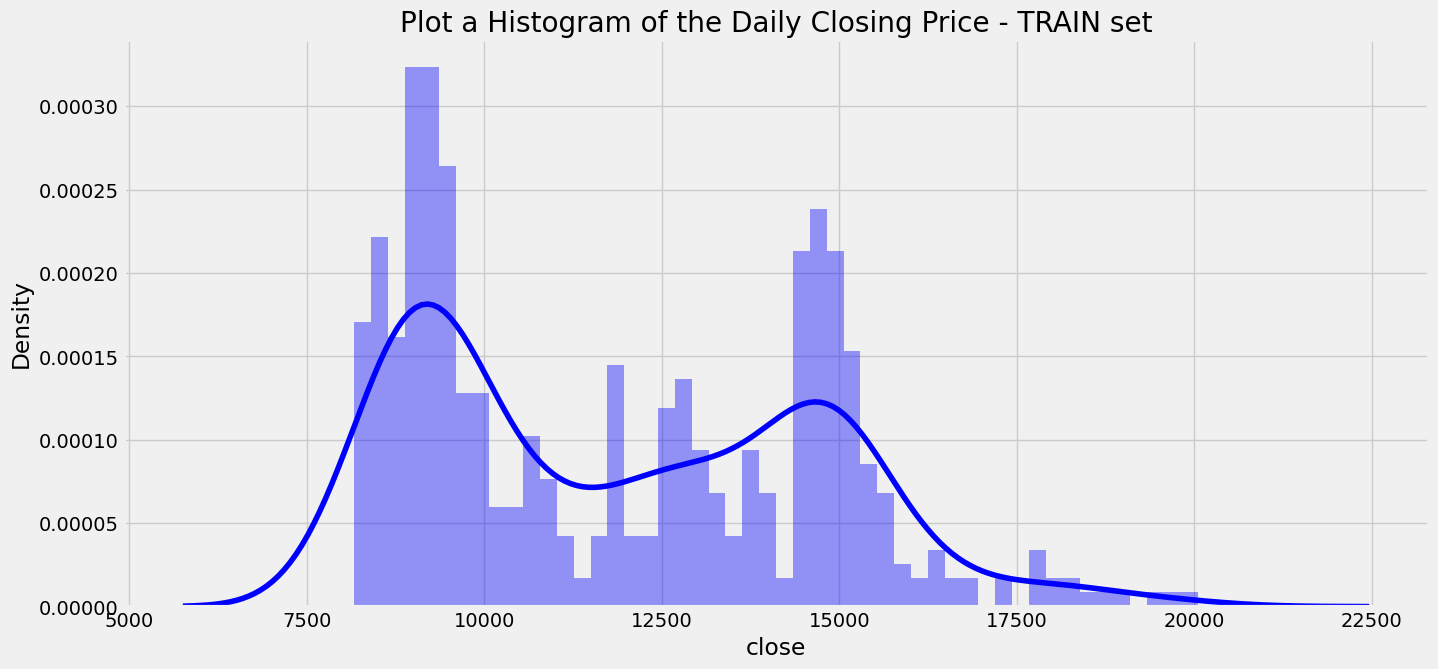

In [100]:
plt.figure(figsize=(15,7))
plt.title("Plot a Histogram of the Daily Closing Price - TRAIN set")
sns.distplot(STOCK['close'].dropna(), bins=50, color='blue');

In [101]:
from sklearn.model_selection import TimeSeriesSplit

# TimeSeriesSplit를 사용하여 학습/검증 데이터를 나눕니다.
tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(df):
    # 학습 데이터와 검증 데이터를 생성합니다.
    X_train, X_val = df.iloc[train_index], df.iloc[val_index]
    print(X_train)
    # 학습 및 예측 코드를 이곳에 추가합니다.
    # 예를 들어, 다음과 같이 사용할 수 있습니다:
    # model = SomeModel()
    # model.fit(X_train)
    # predictions = model.predict(X_val)


             date     code    name  volume   open   high    low  close
0      2021-06-01  A060310      3S  166690   2920   2970   2885   2920
1      2021-06-01  A095570  AJ네트웍스   63836   5780   5940   5750   5780
2      2021-06-01  A006840   AK홀딩스  103691  34400  35600  34150  34400
3      2021-06-01  A054620     APS  462544  14950  14950  13800  14950
4      2021-06-01  A265520   AP시스템  131987  29050  29150  28800  29050
...           ...      ...     ...     ...    ...    ...    ...    ...
164665 2021-09-29  A038460  바이오스마트  119696   5740   5740   5520   5740
164666 2021-09-29  A086040  바이오톡스텍  112478   9150   9330   9130   9150
164667 2021-09-29  A032980     바이온  611453   1390   1420   1325   1390
164668 2021-09-29  A043150      바텍   62263  40600  41150  40100  40600
164669 2021-09-29  A323990   박셀바이오  352002  68800  70200  66700  68800

[164670 rows x 8 columns]
             date     code    name  volume   open   high    low  close
0      2021-06-01  A060310      3S  166690   2920 

<a id="pk"></a>
# *Primary Key*

`RowID` is composed of `date` and `code`.

In [27]:
row_id = (df['date'].apply(lambda date: ''.join(date.split('-'))+'_')
          + df['code'].astype(str))
assert (df['RowId'] == row_id).all()

AttributeError: 'int' object has no attribute 'split'

## Label-Encoding

In [11]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])
train['label'] = le.inverse_transform(train['label'])
val['label'] = le.inverse_transform(val['label'])
train

,img_path,label
1158,../DATA/train/18/236.png,18
467,../DATA/train/18/274.png,18
2506,../DATA/train/10/335.png,10
2454,../DATA/train/10/10.png,10
525,../DATA/train/18/107.png,18
...,...,...
1555,../DATA/train/11/26.png,11
619,../DATA/train/18/702.png,18
1884,../DATA/train/17/4.png,17
1355,../DATA/train/18/595.png,18


## CustomDataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [13]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [14]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Model Define

In [15]:
# !pip install --upgrade efficientnet_pytorch

In [16]:
import torch.nn as nn
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

class FineTunedModel(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedModel, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b1')
        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x



# # Instantiate the model
# model = FineTunedModel(num_classes=len(set(train['label'])))

# # # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the new layers of the model
# num_epochs = 10
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         # Create a dictionary to map each unique label to a numerical value
#         label_map = {label: i for i, label in enumerate(set(labels))}
#         # Convert the string labels to numerical labels using the label map
#         numerical_labels = [label_map[label] for label in labels]
#         # Create a PyTorch tensor from the numerical labels
#         labels_tensor = torch.tensor(numerical_labels, dtype=torch.long)
#         loss = criterion(outputs, labels_tensor)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)

#     # Calculate and print training loss
#     epoch_loss = running_loss / len(train_loader.dataset)
#     print('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

#     # Calculate validation loss
#     val_running_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             outputs = model(inputs)
#             # Create a dictionary to map each unique label to a numerical value
#             label_map = {label: i for i, label in enumerate(set(labels))}
#             # Convert the string labels to numerical labels using the label map
#             numerical_labels = [label_map[label] for label in labels]
#             # Create a PyTorch tensor from the numerical labels
#             labels_tensor = torch.tensor(numerical_labels, dtype=torch.long)
#             loss = criterion(outputs, labels_tensor)
#             val_running_loss += loss.item() * inputs.size(0)

#     # Calculate and print validation loss
#     val_epoch_loss = val_running_loss / len(val_loader.dataset)
#     print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, num_epochs, val_epoch_loss))




## Train

In [17]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            # Create a dictionary to map each unique label to a numerical value
            label_map = {label: i for i, label in enumerate(set(labels))}
            # Convert the string labels to numerical labels using the label map
            numerical_labels = [label_map[label] for label in labels]
            # Create a PyTorch tensor from the numerical labels
            labels = torch.tensor(numerical_labels, dtype=torch.long)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [18]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            # Create a dictionary to map each unique label to a numerical value
            label_map = {label: i for i, label in enumerate(set(labels))}
            # Convert the string labels to numerical labels using the label map
            numerical_labels = [label_map[label] for label in labels]
            # Create a PyTorch tensor from the numerical labels
            labels = torch.tensor(numerical_labels, dtype=torch.long)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

## Run!!

In [19]:
df['label']

0       18
1       18
2       18
3       18
4       18
        ..
3452    14
3453    14
3454    14
3455    14
3456    14
Name: label, Length: 3457, dtype: object

In [20]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [21]:
model = FineTunedModel(num_classes=len(set(df['label'])))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Loaded pretrained weights for efficientnet-b1


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [1], Train Loss : [2.38360] Val Loss : [2.28487] Val Weighted F1 Score : [0.17137]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [2], Train Loss : [1.77153] Val Loss : [2.30174] Val Weighted F1 Score : [0.19980]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [3], Train Loss : [1.25990] Val Loss : [2.48435] Val Weighted F1 Score : [0.19523]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.79058] Val Loss : [2.86283] Val Weighted F1 Score : [0.20932]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.50976] Val Loss : [3.32558] Val Weighted F1 Score : [0.20736]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.37760] Val Loss : [3.54228] Val Weighted F1 Score : [0.20178]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.30469] Val Loss : [3.86999] Val Weighted F1 Score : [0.18968]
Epoch 00007: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.18815] Val Loss : [3.60916] Val Weighted F1 Score : [0.19481]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.09519] Val Loss : [3.62677] Val Weighted F1 Score : [0.18998]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.06866] Val Loss : [3.77031] Val Weighted F1 Score : [0.18374]
Epoch 00010: reducing learning rate of group 0 to 7.5000e-05.


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.04958] Val Loss : [3.76421] Val Weighted F1 Score : [0.19491]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.04391] Val Loss : [3.82544] Val Weighted F1 Score : [0.19069]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.04014] Val Loss : [3.84622] Val Weighted F1 Score : [0.18390]
Epoch 00013: reducing learning rate of group 0 to 3.7500e-05.


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.03568] Val Loss : [3.86279] Val Weighted F1 Score : [0.18844]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.03227] Val Loss : [3.89364] Val Weighted F1 Score : [0.19458]


  0%|          | 0/87 [00:00<?, ?it/s]

## Inference

In [ ]:
test = pd.read_csv(TEST_CSV)

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [ ]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

## Submission

In [ ]:
submit = pd.read_csv(SAMPLE_PATH)

In [ ]:
submit['label'] = preds

In [ ]:
from datetime import datetime, timedelta, timezone
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# 기록 경로
RECORDER_DIR = os.path.join(DATA_PATH, 'results', train_serial)

# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    
RESULT_PATH = os.path.join(RECORDER_DIR, 'submission.csv')

In [ ]:
submit.to_csv(RESULT_PATH, index=False)